# End-To-End  Example of Rain Field Interpolation using PyNNCML
This notebook presents an end-to-end example of of Rain Field Interpolation with two algorithm one is Inverse Distance Weighting (IDW) and the other is GMZ [1] using PyNNCML.
This tutorial is built using the PyNNCML software package, which provides both for rain estimation using CML and for the evaluation of the rain field interpolation algorithms.
We start with obtaining a subset of the OpenMRG dataset and estimation the rain rate using the one step dynamic base line method.
Afterward, we interpolate the rain field using the Inverse Distance Weighting (IDW) and GMZ algorithms.
Finally, we visualize the results and compare the performance of the two algorithms.


Notebook structure
1. Imports and Installation of PyNNCML
2. Build Dataset
3. Build CML Model
4. Run Multiple CMLs
5. Run Inverse Distance Weighting
6. Run GMZ
7. Visualize the results

[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/main/examples/rain_map_interpolation.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [1]:
import sys
import os


if os.path.exists('../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl


Import PyNNCML From Code


In [2]:
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Building  datasets

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:27<00:00, 26.59it/s]


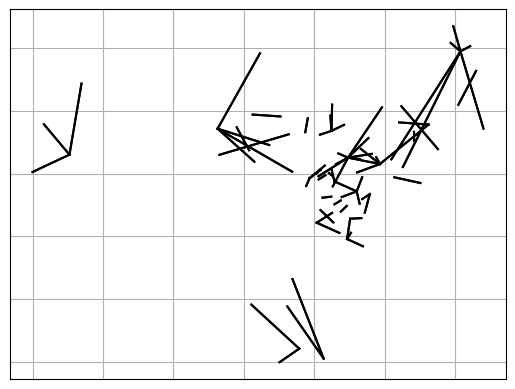

In [3]:
link_set, ps,_ = pnc.datasets.load_open_mrg(time_slice=time_slice, change2min_max=True)
link_set.plot_links(scale=True, scale_factor=64)
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()



# Run multiple CMLs

In [4]:
model = pnc.scm.rain_estimation.one_step_dynamic_baseline(pnc.scm.power_law.PowerLawType.MAX, 0.3, 8,
                                                          quantization_delta=0.3)
imc = pnc.mcm.InferMultipleCMLs(model)
res = imc(link_set)


# Run Inverse Distance Weighting

In [5]:
idw = pnc.mcm.generate_link_set_idw(link_set, roi=3)
rain_map = idw(res).numpy()

# Run GMZ


In [6]:
gmz = pnc.mcm.generate_link_set_gmz(link_set, roi=3)
rain_map_gmz, losses = gmz(res)
rain_map_gmz = rain_map_gmz.numpy()


# Visualize the results

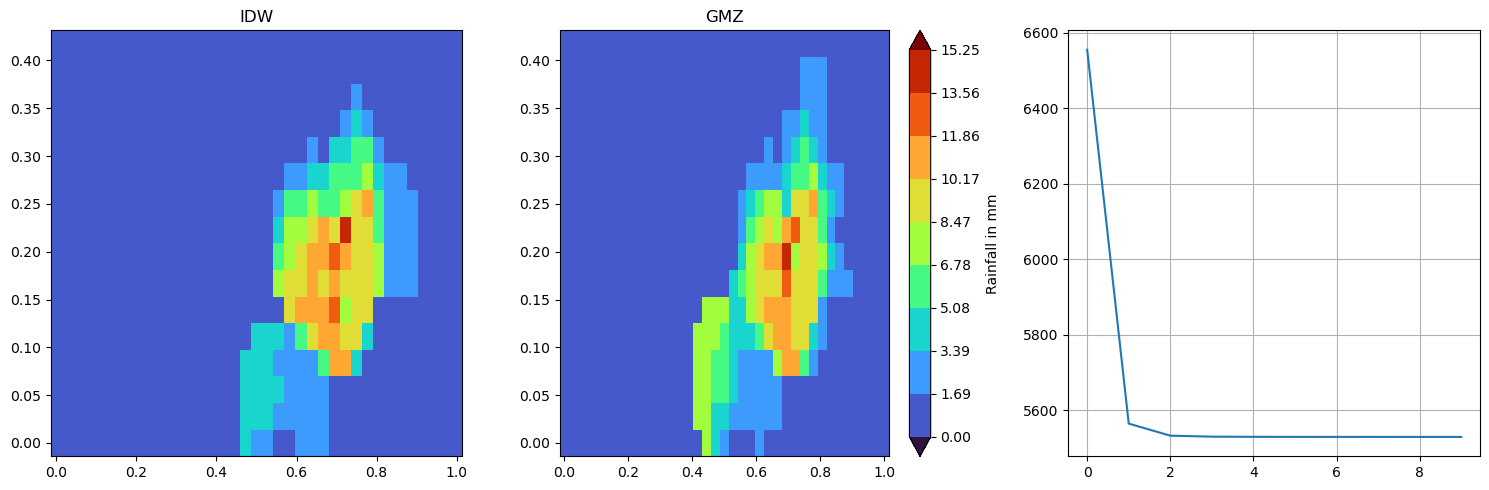

In [10]:
index = np.argmax(np.std(rain_map, axis=(1, 2)))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
peak_rain = np.max([np.max(rain_map), np.max(rain_map_gmz)])
bounds = np.arange(0,peak_rain , peak_rain/10)
# bounds[0] = 1

norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

pc_zero = ax[0].pcolormesh(
    idw.x_grid_vector,
    idw.y_grid_vector,
    rain_map[index, :, :].T,
    shading='nearest',
    cmap='turbo',
    norm=norm,
)
ax[0].set_title('IDW')
pc_one = ax[1].pcolormesh(
    idw.x_grid_vector,
    idw.y_grid_vector,
    rain_map_gmz[index, :, :].T,
    shading='nearest',
    cmap='turbo',
    norm=norm,
)
ax[1].set_title('GMZ')

ax[2].plot(losses[:,index])
ax[2].grid()
fig.colorbar(pc_one, label='Rainfall in mm')
plt.tight_layout()
plt.show()


# References
[1] Goldshtein, Oren, Hagit Messer, and Artem Zinevich. "Rain rate estimation using measurements from commercial telecommunications links." IEEE Transactions on signal processing 57.4 (2009): 1616-1625.